# Machine learning for Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/training.csv')
validation = pd.read_csv('data/validation.csv')


In [3]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
import re

# Dictionary of replacements
replacements = {
    "i" : "I",
    "im" : "I am",
    "Im" : "I am",
    "i m" : "I am",
    "I m" : "I am",
    "hadn t" : "had not",
    "hasn t" : "has not",
    "haven t" : "have not", 
    "don t" : "do not",
    "can t" : "cannot",
    "didn t" : "did not",
    "aren t" : "are not",
    "isn t" : "is not",
    "it s" : "it is",
    "ive" : "I have",
    "it d" : "it would",
    "how d" : "how did",
    "could ve" : "could have",
    "cuz" : "because",
    "gotta" : "got to",
    "kinda" : "kind of",
    "lemme" : "let me",
    "o clock" : "of the clock",
    "y ever" : "have you ever",
    "y know" : "you know",
    "you ll" : "you will",
    "you d" : "you had",
    "why s" : "why is",
    "why re" : "why are",
    "won t" : "will not",
    "would ve": "would have",
    "til" : "until",
    "tis" : "it is",
    "somebody s": "somebody is",
    "someone s": "someone is",
    "mine s" : "mine is"
}

# Function to apply replacements
def replace_words(text, replacements):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in replacements.keys()) + r')\b', re.IGNORECASE)
    return pattern.sub(lambda x: replacements[x.group().lower()], text)

# Remove the contractions in each DataFrame
test['text'] = test['text'].apply(replace_words, replacements=replacements)
train['text'] = train['text'].apply(replace_words, replacements=replacements)
validation['text'] = validation['text'].apply(replace_words, replacements=replacements)

In [5]:
train.head()

,text,label
0,I didnt feel humiliated,0
1,I can go from feeling so hopeless to so damned...,0
2,I am grabbing a minute to post I feel greedy w...,3
3,I am ever feeling nostalgic about the fireplac...,2
4,I am feeling grouchy,3


## Vectorizar TF-IDF

In [4]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train['text'])
X_train = X_train.toarray()
y_train = train['label']

X_val = vectorizer.transform(validation['text'])
X_val = X_val.toarray()
y_val = validation['label']

X_test = vectorizer.transform(test['text'])
X_test = X_test.toarray()
y_test = test['label']

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(16000, 15186)
(2000, 15186)
(2000, 15186)


# MultinomialNB

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
# Modelo inicial
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy inicial en validación: {val_accuracy:.2f}")

Accuracy inicial en validación: 0.64


In [8]:
# Ajuste de hiperparámetros usando el conjunto de validación
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('Best Params:', grid_search.best_params_)

# Mejor modelo y evaluación en validación
best_model = grid_search.best_estimator_

y_val_pred_best = best_model.predict(X_val)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"Accuracy después de ajustar hiperparámetros en validación: {val_accuracy_best:.2f}")

Best Params: {'alpha': 0.1}
Accuracy después de ajustar hiperparámetros en validación: 0.75


In [9]:
# Evaluación final en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en prueba: {test_accuracy:.2f}")
print("Reporte de clasificación en prueba:")
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.74
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       581
           1       0.72      0.95      0.82       695
           2       0.88      0.31      0.46       159
           3       0.87      0.53      0.66       275
           4       0.84      0.51      0.63       224
           5       0.75      0.05      0.09        66

    accuracy                           0.74      2000
   macro avg       0.79      0.54      0.57      2000
weighted avg       0.77      0.74      0.72      2000



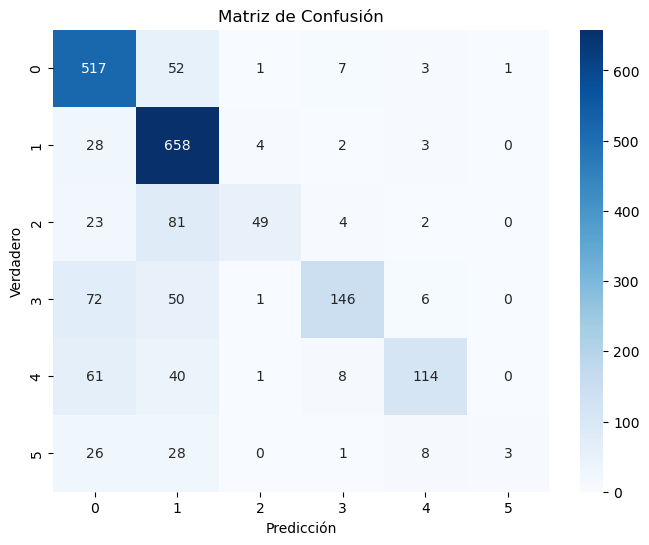

In [10]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_val = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy inicial en validación: {val_accuracy:.2f}")

Accuracy inicial en validación: 0.64


In [13]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en prueba: {test_accuracy:.2f}")
print("Reporte de clasificación en prueba:")
print(classification_report(y_test, y_test_pred))


Accuracy en prueba: 0.74
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       581
           1       0.72      0.95      0.82       695
           2       0.88      0.31      0.46       159
           3       0.87      0.53      0.66       275
           4       0.84      0.51      0.63       224
           5       0.75      0.05      0.09        66

    accuracy                           0.74      2000
   macro avg       0.79      0.54      0.57      2000
weighted avg       0.77      0.74      0.72      2000



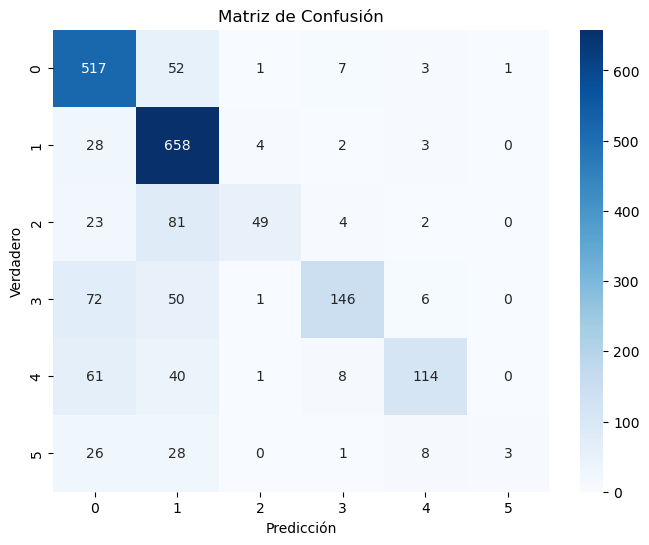

In [14]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Regresión Logística

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
rl = LogisticRegression(random_state=7)
rl.fit(X_train, y_train)

y_pred_val = rl.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy inicial en validación: {val_accuracy:.2f}")

Accuracy inicial en validación: 0.64


/Users/sebastianloeza/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Definir los hiperparámetros a buscar
param_grid = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],  # Solvers disponibles
    'max_iter': [100, 200]  # Número máximo de iteraciones
}

grid_search= GridSearchCV(LogisticRegression(random_state=7), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('Best Params:', grid_search.best_params_)

# Mejor modelo y evaluación en validación
best_model = grid_search.best_estimator_

y_val_pred_best = best_model.predict(X_val)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"Accuracy después de ajustar hiperparámetros en validación: {val_accuracy_best:.2f}")

KeyboardInterrupt: 

In [ ]:
# Evaluación final en el conjunto de prueba

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en prueba: {test_accuracy:.2f}")
print("Reporte de clasificación en prueba:")
print(classification_report(y_test, y_test_pred))


In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()